In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os, json
import matplotlib.pyplot as plt
import ee, geemap
from sklearn.cluster import KMeans
import os, ast

# ==========================
# Configuración de rutas
# ==========================
path = '../PASTIS/PASTIS/'
target_files = sorted(glob(f'{path}ANNOTATIONS/TARGET_*.npy'))

# ==========================
# Mapeo de clases (0..19)
# ==========================
class_mapping = {
  0: "Background",
  1: "Meadow",
  2: "Soft winter wheat",
  3: "Corn",
  4: "Winter barley",
  5: "Winter rapeseed",
  6: "Spring barley",
  7: "Sunflower",
  8: "Grapevine",
  9: "Beet",
  10: "Winter triticale",
  11: "Winter durum wheat",
  12: "Fruits, vegetables, flowers",
  13: "Potatoes",
  14: "Leguminous fodder",
  15: "Soybeans",
  16: "Orchard",
  17: "Mixed cereal",
  18: "Sorghum",
  19: "Void label"
}

# 📘 Dataframe con las hectareas por cultivo para cada parcela

**Intención**  
Calcular, para cada parcela (patch), el **área en hectáreas por tipo de cultivo** usando las máscaras semánticas de PASTIS, y **enriquecer** esos resultados con los **metadatos** del `metadata.geojson` (por ejemplo, `TILE`, fechas, etc.).

**Entradas**  
- `TARGET_*.npy`: matrices panópticas por parche (usamos `target[0]` = clases 0–19).  
- `metadata.geojson`: propiedades por parche (`ID_PATCH`, `TILE`, …).  

**Proceso**  
1. Para cada `TARGET_XXXXX.npy`, extraer `patch_id` y la capa semántica (`target[0]`).  
2. **Contar píxeles por clase**, excluir `0=Background` y `19=Void`.  
3. Convertir píxeles a **hectáreas** (S2 a 10 m ⇒ **1 píxel = 0.01 ha**).  
4. Armar un DataFrame por parcela con **una columna por cultivo** y **total_cultivos_ha**.  
5. Leer `metadata.geojson` y **unir** (merge) por `ID_PATCH ↔ patch_id` para añadir metadatos.

**Output**  
- `df`: tabla por **parcela** con **hectáreas por cultivo** y `total_cultivos_ha`.  
- `metadata_df`: metadatos por parcela (incluye `TILE`, etc.).  
- `df_crops`: **tabla final unida** (cultivos + metadatos), lista para análisis/regiones/modelado.


In [2]:
# Sólo cultivos verdaderos (excluimos 0=Background y 19=Void)
crop_ids = list(range(1, 19))

# Para nombres de columnas legibles
def slug(s): 
    return s.replace(',', '').replace('/', ' ').replace('  ', ' ').replace(' ', '_')

crop_cols = [f"{slug(class_mapping[i])}_ha" for i in crop_ids]

# ==========================
# Construir DataFrame por parcela a partir de TARGET_*.npy
# ==========================
rows = []
for fp in target_files:
    base = os.path.basename(fp)
    patch_id = int(os.path.splitext(base)[0].split('_')[-1])

    semantic = np.load(fp)[0].astype(np.int32)
    counts = np.bincount(semantic.ravel(), minlength=20)
    ha_per_crop = counts[crop_ids] * 0.01  # 10 m → 100 m² = 0.01 ha

    row = {"patch_id": patch_id}
    row.update({col: float(ha) for col, ha in zip(crop_cols, ha_per_crop)})
    row["total_cultivos_ha"] = float(ha_per_crop.sum())
    rows.append(row)

df = pd.DataFrame(rows).sort_values("patch_id").reset_index(drop=True)

cols = (["patch_id", "TILE", "total_cultivos_ha"] + crop_cols) if "TILE" in df.columns \
       else (["patch_id", "total_cultivos_ha"] + crop_cols)
df = df[cols]


# Ruta al GeoJSON de metadatos de PASTIS
metadata_path = "../PASTIS/PASTIS/metadata.geojson"

# 1) Leer el GeoJSON en memoria
with open(metadata_path, "r", encoding="utf-8") as f:
    metadata_json = json.load(f)

# 2) Extraer solo los "properties" de cada parche (feature)
records = [feat["properties"] for feat in metadata_json["features"]]

# 3) Pasar a DataFrame: cada fila = parche, cada columna = atributo del metadato
metadata_df = pd.DataFrame(records)

# 4) Vista rápida de la estructura de los metadatos
metadata_df           # primeras filas

df_crops = metadata_df.merge(df, left_on='ID_PATCH', right_on='patch_id')
df_crops

,Fold,ID_PATCH,N_Parcel,Parcel_Cover,TILE,dates-S2,id,patch_id,total_cultivos_ha,Meadow_ha,...,Beet_ha,Winter_triticale_ha,Winter_durum_wheat_ha,Fruits_vegetables_flowers_ha,Potatoes_ha,Leguminous_fodder_ha,Soybeans_ha,Orchard_ha,Mixed_cereal_ha,Sorghum_ha
0,1,10000,119,0.808032,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10000,10000,125.12,25.51,...,0.00,0.0,0.0,71.19,5.56,0.00,0.0,0.0,0.00,0.0
1,2,10001,111,0.501986,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10001,10001,73.98,31.74,...,0.00,0.0,0.0,24.76,2.83,1.84,0.0,0.0,0.00,0.0
2,4,10002,131,0.638722,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10002,10002,93.43,16.62,...,0.00,0.0,0.0,38.84,4.43,0.00,0.0,0.0,0.00,0.0
3,5,10003,75,0.866824,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10003,10003,110.09,0.00,...,18.38,0.0,0.0,8.11,15.58,0.00,0.0,0.0,0.00,0.0
4,4,10004,46,0.204906,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10004,10004,30.01,0.00,...,0.00,0.0,0.0,23.17,2.42,0.56,0.0,0.0,3.22,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,2,40558,33,0.783991,t32ulu,"{'0': 20180917, '1': 20180922, '2': 20180927, ...",40558,40558,100.94,22.08,...,0.00,0.0,0.0,0.00,0.00,7.96,0.0,0.0,8.37,0.0
2429,5,40559,24,0.129896,t32ulu,"{'0': 20180917, '1': 20180922, '2': 20180927, ...",40559,40559,17.59,1.54,...,9.90,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
2430,3,40560,7,0.255358,t32ulu,"{'0': 20180917, '1': 20180922, '2': 20180927, ...",40560,40560,40.27,40.27,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
2431,3,40561,5,0.054305,t32ulu,"{'0': 20180917, '1': 20180922, '2': 20180927, ...",40561,40561,7.56,7.56,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0


# 📊 Distribución de cultivos por región 

**Intención**  
A partir de un DataFrame de parcelas con hectáreas por cultivo y su región (`TILE`), el objetivo es:
1) **Agregarlas por región** para obtener el total de hectáreas por cultivo en cada `TILE`.  
2) **Convertir esos totales a porcentajes** (composición) para cada región.  
3) **Visualizar** la **composición relativa** de cultivos por región con una **gráfica de barras apiladas al 100%** (cada barra = 100%, segmentos = % por cultivo).

### Entradas 

- `df_crops` ya construido (cultivos + metadatos).  
- Columnas:
  - `TILE`: identificador de región/tesela Sentinel-2.
  - `*_ha`: una columna por cultivo con **área en hectáreas** (p.ej., `Corn_ha`, `Sunflower_ha`, …).
  - `total_cultivos_ha`: suma de hectáreas por cultivo (no se usa para el cálculo de composición).


### Output

- Una **comparación directa de la composición** de cultivos entre regiones:  
  - **No** muestra área absoluta; **sí** muestra **mezcla relativa** (proporciones).  
  - Útil para ver **dominancias** o **diversidad** de cultivos por `TILE`.  
- La **leyenda** lista los cultivos (nombre derivado de la columna `_ha`).


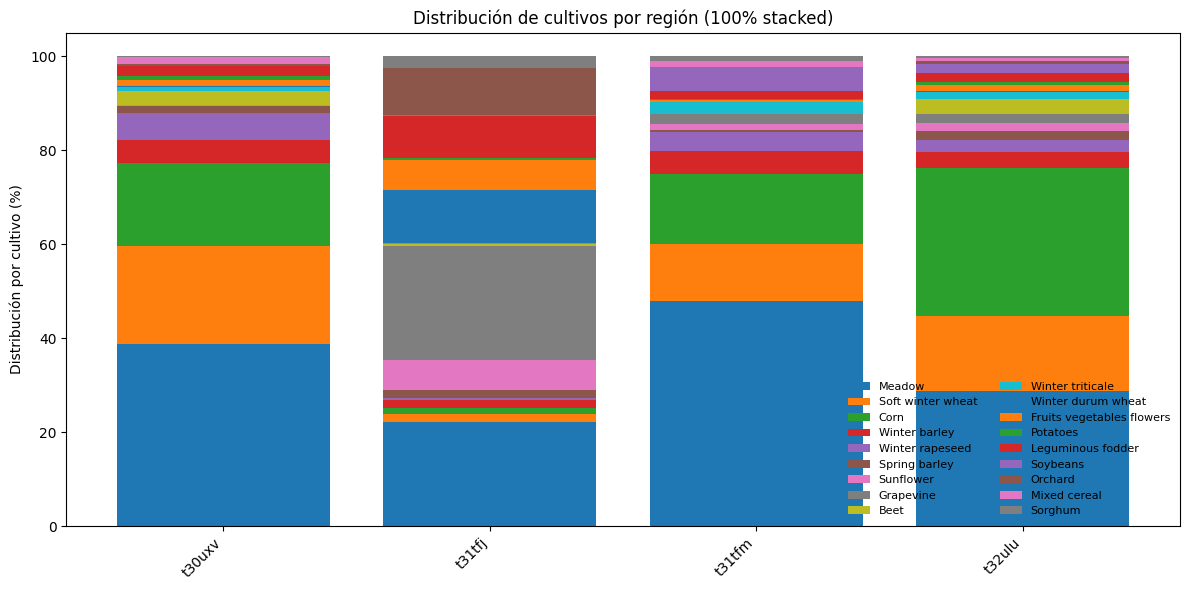

In [ ]:
df = df_crops.copy()

# Columnas de cultivos (todas *_ha excepto el total)
crop_cols = [c for c in df.columns if c.endswith("_ha") and c != "total_cultivos_ha"]
assert "TILE" in df.columns, "Falta la columna TILE en el DataFrame."
assert len(crop_cols) > 0, "No se encontraron columnas *_ha de cultivos."


df[crop_cols] = df[crop_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

# Agregar por región en hectáreas
gb_ha = df.groupby("TILE")[crop_cols].sum().sort_index()

# Convertir a porcentajes por región (cada barra suma 100)
gb_pct = gb_ha.div(gb_ha.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100.0

# --- Plot: 100% stacked bar ---
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(gb_pct), dtype=float)
x = np.arange(len(gb_pct.index))

for col in crop_cols:
    ax.bar(x, gb_pct[col].values, bottom=bottom, label=col.replace("_ha", "").replace("_", " "))
    bottom += gb_pct[col].values

ax.set_xticks(x)
ax.set_xticklabels(gb_pct.index, rotation=45, ha='right')
ax.set_ylabel("Distribución por cultivo (%)")
ax.set_title("Distribución de cultivos por región (100% stacked)")
ax.legend(ncol=2, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()


# 🗺️ Visualizar parcelas en Earth Engine desde un CSV (PASTIS)

## 🎯 Intención
Cargar **todas las parcelas** de PASTIS como un **Asset de tabla** en Google Earth Engine (GEE) a partir de un **CSV con polígonos**, para luego **mostrarlas en un mapa**

---

## 🔄 Flujo para generar el Asset (CSV → Earth Engine)

1. **Preparar el CSV de parcelas**
   - Columnas recomendadas:  
     - `patch_id` (ID de la parcela), `TILE` (tesela/región) y **`WKT`** con la geometría del polígono.  
   - Asegura el **CRS = EPSG:4326 (lat/lon)** del WKT.  
   - Ejemplo mínimo de columnas: `patch_id,TILE,WKT`.

2. **Subir el CSV a Earth Engine**
   - En el **Code Editor**: *Assets* → **NEW** → **Table upload**.  
   - Selecciona tu **CSV**.  
   - En “Geometry”: elige **WKT** y **EPSG:4326**.  
   - Asigna nombre al Asset, p. ej.:  
     `projects/tu-proyecto/assets/pastis_parcels_wkt`.  
   - Sube, espera a que termine el **ingest**.

3. **Verificar propiedades**
   - Abre el Asset y confirma que están los campos (p. ej., `patch_id`, `TILE`) y que la geometría es válida.

## Output
- **Contornos por parcela**: `ee.Image().byte().paint(fc, 1, 3)`.  
- **Relleno semitransparente**: `paint(fc, 1).visualize(palette=['#ff0000'], opacity=0.2)`.  
- **Filtrar por ID**: `fc.filter(ee.Filter.eq('patch_id', 10000))`.  
- **Etiquetas**: calcula centroides y pinta `patch_id` para referencia visual.


In [4]:
ee.Initialize(project='fonseca-472504')

ASSET = 'projects/fonseca-472504/assets/pastis_parcels_wkt'
fc = ee.FeatureCollection(ASSET)
geom = fc.geometry()

m = geemap.Map()
m.centerObject(geom, 14)

outline = ee.Image().byte().paint(geom, 1, 3)  # valor=1, ancho=3 px
m.addLayer(outline.visualize(palette=['red']), {}, 'Patch 10000 (outline)', True)

m

Map(center=[46.81571671022632, 4.235892452217402], controls=(WidgetControl(options=['position', 'transparent_b…

# Selección de parcelas representativas por **región** para correr K-Means

No podemos meter **todas** las parcelas a K-Means (memoria/tiempo). La idea es **elegir N parcelas** dentro de una **región (TILE)** cuya **mezcla de cultivos** sea lo más parecida posible a la **distribución real** de la región. Así entrenas/validas con un subconjunto **representativo**.

---

## ¿Qué entra?
- `df`: DataFrame por **parcela**, con:
  - `patch_id`
  - `TILE` (región/tesela)
  - Columnas de área por cultivo en **hectáreas**: `*_ha` (ej. `Corn_ha`, `Sunflower_ha`, …)
  - (Opcional) `total_cultivos_ha`
- Parámetros:
  - `REGION_TILE`: la región a muestrear (p. ej. `"t30uxv"`).
  - `N_SELECT`: cuántas parcelas quieres (10, 20, 50, …).

---

## ¿Qué hace?
1. **Filtra** `df` por la región (`TILE == REGION_TILE`).
2. Detecta automáticamente las columnas de cultivos (`*_ha`, excluyendo `total_cultivos_ha`).
3. Calcula la **distribución objetivo** de la región:
   - Suma hectáreas por cultivo en la región → vector `total_by_class`.
   - Normaliza a porcentajes → `target`.
4. **Selección greedy** (codiciosa) de `N_SELECT` parcelas:
   - Iterativamente prueba añadir cada candidata a lo ya seleccionado.
   - Tras añadirla virtualmente, recalcula la **distribución seleccionada** y mide su **distancia L1** a la distribución objetivo.
   - Elige la parcela que **minimiza la distancia L1**; en empate, prioriza la de **mayor área añadida**.
   - Actualiza el conjunto seleccionado y repite hasta llegar a `N_SELECT` (o quedarte sin candidatas).
5. Devuelve:
   - `sel`: DataFrame de **parcelas seleccionadas** (ordenadas por `patch_id`).
   - Métrica de calidad: **distancia L1** entre la mezcla seleccionada y la regional (0 → encaje perfecto).
   - Lista de `patch


In [ ]:
# === Parámetros ===
REGION_TILE = "t30uxv"   # <- la región (TILE) que quieres
N_SELECT    = 50        # <- cuántas parcelas 

# Filtrar por la región elegida 
df_reg = df[df["TILE"].str.lower() == REGION_TILE.lower()].copy()
if df_reg.empty:
    raise ValueError(f"No hay parcelas en la región '{REGION_TILE}'.")

# Columnas de cultivos (todas las que terminan en _ha excepto el total)
crop_cols = [c for c in df_reg.columns if c.endswith("_ha") and c != "total_cultivos_ha"]

# Distribución objetivo (dentro de la región)
total_by_class = df_reg[crop_cols].sum(axis=0).to_numpy(dtype=float)
total_all = total_by_class.sum()
target = total_by_class / (total_all if total_all > 0 else 1.0)

# Selección greedy dentro de la región: minimiza ||dist_sel - target||_1
selected_idx = []
sel_sum = np.zeros(len(crop_cols), dtype=float)
candidates = set(df_reg.index.tolist())

for _ in range(min(N_SELECT, len(df_reg))):
    best_idx = None
    best_metric = None
    best_tiebreak = None  # desempate: mayor área añadida

    for idx in candidates:
        cand = df_reg.loc[idx, crop_cols].to_numpy(dtype=float)
        new_sum = sel_sum + cand
        new_total = new_sum.sum()
        if new_total <= 0:
            continue
        new_dist = new_sum / new_total
        metric = np.abs(new_dist - target).sum()
        tiebreak = cand.sum()

        if (best_metric is None) or (metric < best_metric) or (metric == best_metric and tiebreak > best_tiebreak):
            best_metric = metric
            best_tiebreak = tiebreak
            best_idx = idx

    if best_idx is None:
        break
    selected_idx.append(best_idx)
    sel_sum += df_reg.loc[best_idx, crop_cols].to_numpy(dtype=float)
    candidates.remove(best_idx)

sel = df_reg.loc[selected_idx].copy().sort_values("patch_id").reset_index(drop=True)

# Métrica final vs objetivo regional
sel_total = sel[crop_cols].sum(axis=0).to_numpy(dtype=float)
sel_total_sum = sel_total.sum()
sel_dist = sel_total / (sel_total_sum if sel_total_sum > 0 else 1.0)
l1_dist = np.abs(sel_dist - target).sum()

print(f"TILE: {REGION_TILE}")
print("patch_id seleccionados:", sel["patch_id"].tolist())
print("N seleccionadas:", len(sel))
print(f"Distancia L1 vs distribución regional: {l1_dist:.4f}")

# K-Means sobre **Satellite Embedding** (GEE) para un subconjunto de parcelas seleccionadas

## Objetivo
Aplicar **K-Means no supervisado** a los **embeddings satelitales anuales** de Google (`GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL`) sobre un **subconjunto representativo** de parcelas (la lista `IDS` viene de la selección previa “greedy” por región).  
El objetivo es **segmentar patrones espectro-temporales** dentro de las parcelas y **visualizarlos en el mapa**, además de **cuantificar el área** de cada clúster.

---

## Entradas
- **`ASSET`**: Tabla de parcelas (Asset GEE) con geometrías y campo `patch_id`.
- **`IDS`**: Lista de `patch_id` seleccionados (p. ej., salida de la heurística por región).
- **`YEAR`**: Año a consultar en el embedding anual.
- **`BANDS`**: 64 bandas `A00..A63` del embedding.
- **`K`**: Número de clústeres a formar (p. ej., 18).
- **`SAMPLE`**: Nº de píxeles muestreados para entrenar el K-Means.
- **`SCALE`**: Resolución (m) para muestreo/reducciones.
- **`PREVIEW_M`**: Resolución de tiles para visualizar (ajuste para evitar “memory limit”).

---

## Flujo del script
1. **Filtrado de parcelas**  
   - Carga el `FeatureCollection` con todas las parcelas y filtra por `IDS`.  
   - Construye una **máscara** para limitar todo el análisis al interior de esas parcelas.

2. **Embedding anual**  
   - Filtra la colección `GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL`


In [ ]:
def print_area_by_cluster(clusters_img, geom, scale=10):
    areas = (ee.Image.pixelArea().addBands(clusters_img)
             .reduceRegion(ee.Reducer.sum().group(groupField=1, groupName='cluster'),
                           geometry=geom, scale=scale, maxPixels=1e13, tileScale=4))
    groups = ee.List(areas.get('groups')).getInfo() or []
    total = sum(g['sum'] for g in groups) if groups else 0
    print("Área por clúster:")
    for g in sorted(groups, key=lambda x: x['cluster']):
        pct = 100.0 * g['sum'] / total if total else 0
        print(f"  C{g['cluster']}: {int(g['sum']):,} m²  ({pct:5.2f} %)")


ee.Initialize(project='fonseca-472504')

# ===== Config mínima =====
ASSET = 'projects/fonseca-472504/assets/pastis_parcels_wkt' 
IDS   = sel["patch_id"].tolist()
YEAR  = 2019
K_MIN, K_MAX = 2, 12
K  = 18
SAMPLE = 4000
SCALE  = 10
PREVIEW_M = 10  # tamaño píxel para ver 
BANDS = [f'A{i:02d}' for i in range(64)]
PALETTE = ['#440154','#31688e','#35b779','#fde725','#ff7f00',
           '#a51f99','#4daf4a','#984ea3','#e41a1c','#377eb8'][:K]

# ===== Selección de parcelas =====
fc_all = ee.FeatureCollection(ASSET)
fc_sel = fc_all.filter(ee.Filter.inList('patch_id', IDS)) 
geom   = fc_sel.geometry()
mask   = ee.Image().byte().paint(fc_sel, 1)  # limitar todo al interior

# ===== Embedding anual =====
start = ee.Date.fromYMD(YEAR, 1, 1)
end   = start.advance(1, 'year')
emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate(start, end).filterBounds(geom)
       .mosaic().select(BANDS)
       .updateMask(mask).clip(geom))

# ===== K-means (simple) =====
training  = emb.sample(region=geom, scale=SCALE, numPixels=SAMPLE, seed=42, geometries=False)
clusterer = ee.Clusterer.wekaKMeans(K).train(training)
clusters  = emb.cluster(clusterer).rename('cluster').updateMask(mask)

# ===== Mapa (ligero) =====
m = geemap.Map()
m.add_basemap('SATELLITE')
m.centerObject(geom, 13)

# borde de las parcelas seleccionado (rojo)
outline = ee.Image().byte().paint(fc_sel, 1, 3)
m.addLayer(outline.visualize(palette=['red']), {}, 'Parcelas', True)

# --- Etiquetas con el patch_id en el centroide de cada parcela seleccionada ---

centroids = fc_sel.map(
    lambda f: ee.Feature(
        f.geometry().centroid(10),   # centroide a ~10 m
        {'patch_id': f.get('patch_id')}
    )
)

# Texto: el valor de 'patch_id'
m.add_labels(
    centroids,
    'patch_id',          
    font_size='10pt',
    font_color='white'
)

print_area_by_cluster(clusters, geom)
# clústeres en RGB 8-bit + proyección web (sin reduceResolution)
vis = clusters.toByte().visualize(min=0, max=K-1, palette=PALETTE).unmask(0)
m.addLayer(vis.reproject('EPSG:3857', None, PREVIEW_M), {}, f'Clusters K={K}', True)

m


Área por clúster:
  C0: 6,429,737 m²  ( 7.87 %)
  C1: 2,181,820 m²  ( 2.67 %)
  C2: 2,208,644 m²  ( 2.70 %)
  C3: 5,310,971 m²  ( 6.50 %)
  C4: 2,482,360 m²  ( 3.04 %)
  C5: 3,333,669 m²  ( 4.08 %)
  C6: 6,919,254 m²  ( 8.47 %)
  C7: 6,536,443 m²  ( 8.00 %)
  C8: 5,727,413 m²  ( 7.01 %)
  C9: 5,272,672 m²  ( 6.46 %)
  C10: 6,654,833 m²  ( 8.15 %)
  C11: 4,567,116 m²  ( 5.59 %)
  C12: 6,957,316 m²  ( 8.52 %)
  C13: 4,253,176 m²  ( 5.21 %)
  C14: 4,901,710 m²  ( 6.00 %)
  C15: 2,637,397 m²  ( 3.23 %)
  C16: 620,159 m²  ( 0.76 %)
  C17: 4,673,264 m²  ( 5.72 %)


Map(center=[49.030075761759406, -0.8824335445864879], controls=(WidgetControl(options=['position', 'transparen…

# Codo de K (K-Means) con **Satellite Embedding** muestreado desde GEE

**Objetivo**  
Estimar un **K razonable** para K-Means usando una **muestra de píxeles** del embedding satelital anual (`GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL`) extraída **dentro de las parcelas seleccionadas** (por `IDS` o `TILE`). Se calcula la **gráfica de codo** (inercia vs. K) en el cliente (Python) para decidir K antes de clusterizar en GEE.


## Entradas
- `ASSET`: tabla de parcelas en GEE (con `patch_id` / `TILE`).
- `IDS` **o** `TILE`: define el subconjunto de parcelas a analizar.
- `YEAR`: año del embedding anual.
- `BANDS`: `A00..A63` (64 dims).
- `SCALE`: resolución (m) para muestrear.
- `SAMPLE`: nº de píxeles a traer a cliente (controla memoria/tiempo).
- Rango de K: `K_MIN..K_MAX`.


## Proceso
1. **Geometría y máscara**  
   - Filtra `fc_all` → `fc_sel` (por `IDS` o `TILE`), obtiene `geom` y crea `mask` para limitar al interior de las parcelas.
2. **Embedding anual**  
   - Filtra por `YEAR` y `geom`, hace `mosaic()`, selecciona `A00..A63`, aplica `updateMask(mask)` y `clip(geom)`.
3. **Muestreo a cliente**  
   - `emb.sample(...)` con `numPixels=SAMPLE`.  
   - Convierte a `numpy` → matriz `X` de dimensión `n × 64`.
4. **Barrido de K (codo)**  
   - Para `K_MIN..K_MAX`: ajusta K-Means en `X` y guarda la **inercia** (SSE).  
   - Grafica **inercia vs. K**.  
   - (Opcional) propone un `K` heurístico por **máxima caída relativa**.


## Ouput
- **Gráfica de codo** para orientar la elección de `K`.  
- **Tamaño de la muestra** (`n` píxeles) usado para el análisis.  
- **K sugerido** (heurístico) opcional.




Muestra: (3984, 64)


Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\LuisA\.conda\envs\dinov3\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\LuisA\.conda\envs\dinov3\lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\LuisA\.conda\envs\dinov3\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\LuisA\.conda\envs\dinov3\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\LuisA\.conda\envs\dinov3\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa2 in position 115: invalid start byte


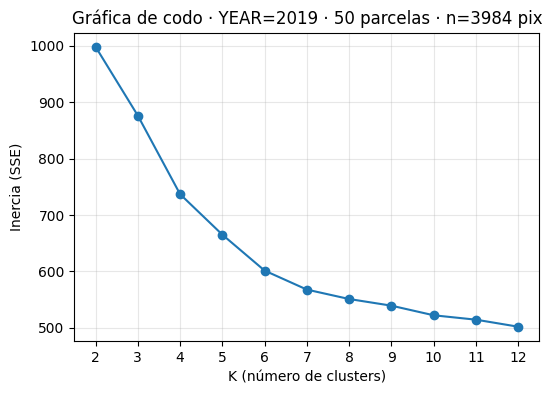

K sugerido (heurístico): 4


In [ ]:
# ========= Geometría de las parcelas =========
fc_all = ee.FeatureCollection(ASSET)
fc_sel = fc_all.filter(ee.Filter.inList('patch_id', IDS))        
geom   = fc_sel.geometry()
mask   = ee.Image().byte().paint(fc_sel, 1)

# ========= Embedding anual =========
start = ee.Date.fromYMD(YEAR, 1, 1)
end   = start.advance(1, 'year')
emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate(start, end).filterBounds(geom)
       .mosaic().select(BANDS)
       .updateMask(mask).clip(geom))

# ========= Muestra a cliente (X: n x 64) =========
fc_samples = emb.sample(region=geom, scale=SCALE, numPixels=SAMPLE, seed=42, geometries=False)
samples = fc_samples.getInfo()['features']  # trae ~SAMPLE filas
X = np.array([[feat['properties'][b] for b in BANDS] for feat in samples], dtype=np.float32)
print("Muestra:", X.shape)

# ========= Barrido de K y gráfica de codo =========
inertias = []
Ks = list(range(K_MIN, K_MAX + 1))
for k in Ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)   # suma de distancias cuadradas a centroides

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.xticks(Ks)
plt.xlabel('K (número de clusters)')
plt.ylabel('Inercia (SSE)')
plt.title(f'Gráfica de codo · YEAR={YEAR} · {len(IDS)} parcelas · n={len(X)} pix')
plt.grid(True, alpha=0.3)
plt.show()

# (Opcional) sugerencia rápida del "codo" por máxima caída relativa
drops = np.diff(inertias) / np.array(inertias[:-1])
if len(drops) > 0:
    k_sugerido = Ks[1:][int(np.argmin(drops))]  # donde la caída relativa es mayor
    print("K sugerido (heurístico):", k_sugerido)

# Visualización panóptica de una parcela PASTIS (clases + instancias)

**Objetivo**  
Cargar un **parche específico** (`PATCH_ID`) de PASTIS, mostrar su **segmentación panóptica**: fondo con **clases semánticas** (0–19) y **contornos de instancias**; además, **etiquetar** las instancias más grandes con su **clase dominante**. (Opcional) leer `metadata.csv` para reportar una **fecha Sentinel-2** del `YEAR`.


## Entradas
- `TARGET_{PATCH_ID}.npy` en `ANNOTATIONS/`:
  - `target[0]`: **semantic** (clases 0–19)
  - `target[1]`: **instances** (ID por objeto; `0`=sin instancia)
- (Opcional) `metadata.csv` con columnas `ID_PATCH` y `dates-S2`.
- Parámetros: `PATCH_ID`, `YEAR`, `PATH`.


## Proceso
1. **Carga** del `TARGET_{PATCH_ID}.npy` → `semantic`, `instances`.
2. (Opcional) **Lee** `metadata.csv`, filtra por `PATCH_ID` y muestra una **fecha** del `YEAR`.
3. **Cálculos auxiliares**:
   - `instance_edges`: bordes por diferencia con vecinos.
   - `top_instances_by_area(k)`: IDs de las **k** instancias más grandes.
   - `instance_centroid` y `instance_majority_class`: centroide y **clase dominante** por instancia.
4. **Gráfico**:
   - Fondo: `semantic` con paleta categórica y **colorbar** etiquetado con clases presentes.
   - Overlay: **contornos** de `instances`.
   - **Etiquetas** sobre las `k` instancias mayores: “`Clase (inst_id)`”.


## Salidas
- **Figura**: mapa panóptico con clases + contornos + etiquetas.
- **Consola**: `PATCH_ID`, clases presentes, y (si aplica) una fecha de `YEAR` encontrada en `dates-S2`.


PATCH_ID: 10284
Clases presentes (semantic): [ 0  1  2  3  5  9 11 14 19]
metadata.csv no encontrado (este paso es opcional).


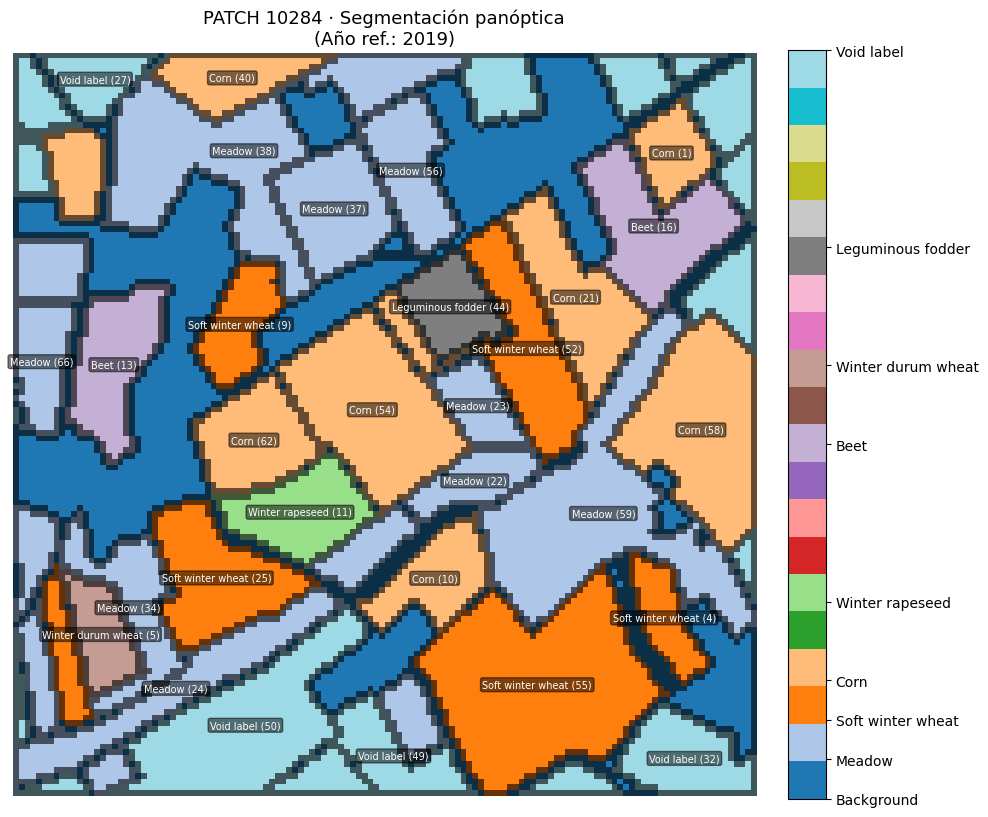

In [ ]:
# ==========================
# Elige parcela y año
# ==========================
PATH = '../PASTIS/PASTIS/'    
PATCH_ID = 10284        # <-- parcela que quieres ver
YEAR = 2019             # <-- año de interés

# ==========================
# Cargar TARGET de la parcela
# ==========================
target_file = os.path.join(PATH, f'ANNOTATIONS/TARGET_{PATCH_ID}.npy')
target = np.load(target_file)

semantic  = target[0].astype(int)  # (H,W) clases 0..19
instances = target[1].astype(int)  # (H,W) id de instancia (0 = fondo/sin inst.)

print("PATCH_ID:", PATCH_ID)
print("Clases presentes (semantic):", np.unique(semantic))

# ==========================
# (Opcional) Mostrar una fecha del YEAR si tienes metadata con 'dates-S2'
# ==========================
meta_csv_1 = os.path.join(PATH, 'metadata.csv')                # ruta posible
meta_csv_2 = os.path.join(PATH, 'METADATA', 'metadata.csv')    # otra ruta posible

if os.path.exists(meta_csv_1) or os.path.exists(meta_csv_2):
    meta_csv = meta_csv_1 if os.path.exists(meta_csv_1) else meta_csv_2
    dfm = pd.read_csv(meta_csv)
    # Suponemos columnas: 'ID_PATCH' y 'dates-S2' (cadena con lista de fechas)
    row = dfm.loc[dfm['ID_PATCH'] == PATCH_ID]
    if len(row) == 1 and 'dates-S2' in row.columns:
        # Convierte la cadena de lista a lista real
        try:
            dates_list = ast.literal_eval(row.iloc[0]['dates-S2'])
            year_dates = [d for d in dates_list if str(YEAR) in d]
            if year_dates:
                print(f"Año {YEAR} → ejemplo de fecha disponible:", year_dates[0])
            else:
                print(f"No encontré fechas en {YEAR} para el PATCH {PATCH_ID}.")
        except Exception as e:
            print("No pude interpretar 'dates-S2':", e)
    else:
        print("No encontré la fila/columna esperada en metadata para este PATCH.")
else:
    print("metadata.csv no encontrado (este paso es opcional).")



# ==========================
# Helpers mínimos (contornos/etiquetas)
# ==========================
max_labels = 30  

def instance_edges(inst_map):
    up    = inst_map != np.roll(inst_map,  1, axis=0)
    down  = inst_map != np.roll(inst_map, -1, axis=0)
    left  = inst_map != np.roll(inst_map,  1, axis=1)
    right = inst_map != np.roll(inst_map, -1, axis=1)
    edges = up | down | left | right
    edges[0,:] = edges[-1,:] = edges[:,0] = edges[:,-1] = True
    return edges

def top_instances_by_area(inst_map, k=30):
    ids, counts = np.unique(inst_map, return_counts=True)
    mask = ids != 0
    ids, counts = ids[mask], counts[mask]
    order = np.argsort(counts)[::-1]
    return ids[order][:k]

def instance_centroid(inst_map, inst_id):
    ys, xs = np.where(inst_map == inst_id)
    return float(ys.mean()), float(xs.mean())

def instance_majority_class(semantic_map, inst_map, inst_id):
    ys, xs = np.where(inst_map == inst_id)
    classes = semantic_map[ys, xs].astype(int)
    counts = np.bincount(classes, minlength=20)
    return int(counts.argmax())

# ==========================
# Plot panóptico
# ==========================
present_classes = np.unique(semantic)
cmap = plt.get_cmap('tab20', 20)
vmin, vmax = 0, 19

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(semantic, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_title(f"PATCH {PATCH_ID} · Segmentación panóptica\n(Año ref.: {YEAR})", fontsize=13)
ax.axis('off')

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=present_classes)
cbar.ax.set_yticklabels([class_mapping.get(int(c), str(int(c))) for c in present_classes])

edges = instance_edges(instances)
ax.imshow(np.where(edges, 1, np.nan), cmap='gray', alpha=0.6)

label_ids = top_instances_by_area(instances, k=max_labels)
for inst_id in label_ids:
    cy, cx = instance_centroid(instances, inst_id)
    maj_cls = instance_majority_class(semantic, instances, inst_id)
    cls_name = class_mapping.get(maj_cls, "Unknown")
    ax.text(
        cx, cy,
        f"{cls_name} ({inst_id})",
        color='white', fontsize=7, ha='center', va='center',
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2')
    )

plt.tight_layout()
plt.show()


# Métricas derivadas (Sentinel-2) y qué significan

**Intención del bloque:** calcular **rasters de métricas biofísicas** a partir de Sentinel-2 SR en una ventana de crecimiento (`GROW_START`→`GROW_END`) y **limitadas a tus parcelas**. Luego puedes **visualizarlas** o **agregarlas por parcela** para usarlas como features en modelos.

## Métricas espectrales/índices (rasters)

**Pre-proceso**: Sentinel-2 SR con máscara de **nube/cirros** (QA60) y **reflectancia** en [0, 1].

### NDVI (Normalized Difference Vegetation Index)
- **Cómo se calcula**: `NDVI = (B8 − B4) / (B8 + B4)`.  
- **Métricas**:
  - **`NDVI_p10`, `NDVI_p50`, `NDVI_p90`** — Percentiles 10/50/90 en la ventana.  
    - Rango típico: ~[0, 0.9].  
    - **p50** ~ vigor “típico” de la estación; **p90** ~ máximos (picos de verdor).
  - **`NDVI_amp` = p90 − p10** — **Amplitud fenológica**.  
    - Captura la **variabilidad intra-estacional** (cultivos anuales suelen tener amplitudes altas; cultivos perennes/pasturas, más bajas).

### EVI (Enhanced Vegetation Index)
- **Cómo se calcula**: `2.5*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)`.  
- **`EVI_med`** — Mediana temporal en la ventana.  
  - Menos saturación a LAI alto; más robusto al **suelo desnudo** y **atmósfera** que NDVI.

### NDWI (Normalized Difference Water Index, Green–NIR)
- **Cómo se calcula**: `(B3 − B8) / (B3 + B8)`.  
- **`NDWI_med`** — Mediana temporal.  
  - Sensible a **humedad** de vegetación/suelo; >0 suele indicar **más humedad/agua**.

### Medianas espectrales Sentinel-2
- **`B2_med`, `B3_med`, `B4_med`, `B8_med`, `B11_med`, `B12_med`** — **median** por banda.  
  - Insumos “crudos” para modelos; posibilitan componer **TrueColor** (B4,B3,B2) o **NIR-RG** (B8,B4,B3) para QC visual.

### Cobertura temporal
- **`S2_obs_count`** — Nº de **observaciones limpias** en la ventana.  
  - Proxy de **calidad de muestreo** (más imágenes = métricas más estables).  
  - Útil como **feature de control** o para **filtrar** parcelas con cobertura pobre.


In [ ]:

# ====== INIT ======
try:
    ee.Number(1).getInfo()
except Exception:
    ee.Initialize(project='fonseca-472504')

# ====== Config ======
ASSET = 'projects/fonseca-472504/assets/pastis_parcels_wkt'
YEAR  = 2019
GROW_START = ee.Date.fromYMD(YEAR, 3, 1)
GROW_END   = ee.Date.fromYMD(YEAR,10,31)
SCALE = 10
PREVIEW_M = 40   

# Filtra por región o por lista (elige uno)
FILTER_TILE = None            
IDS = sel["patch_id"].tolist()  

BANDS_S2 = ['B2','B3','B4','B8','B11','B12']

# ====== Parcelas (reusa si ya existen) ======
try:
    fc, geom_all, mask_fc  # ya existen
except NameError:
    fc_all = ee.FeatureCollection(ASSET)
    if FILTER_TILE:
        fc = fc_all.filter(ee.Filter.eq('TILE', FILTER_TILE))
    elif IDS:
        fc = fc_all.filter(ee.Filter.inList('patch_id', IDS))
    else:
        fc = fc_all

    # métrica simple (opcional)
    PI = ee.Number(math.pi)
    def add_shape(f):
        g = f.geometry()
        area_m2 = g.area(1)
        perim_m = g.perimeter(1)
        compact = ee.Number(4).multiply(PI).multiply(area_m2).divide(perim_m.pow(2))
        return f.set({'area_ha': area_m2.divide(10000), 'perim_m': perim_m, 'compactness': compact})
    fc = fc.map(add_shape)

    geom_all = fc.geometry()
    mask_fc  = ee.Image().byte().paint(fc, 1)

# ====== Sentinel-2 (con máscara de nubes) ======
def _mask_s2_sr(img):
    qa = img.select('QA60')
    cloud = qa.bitwiseAnd(1 << 10).eq(0)
    cirrus = qa.bitwiseAnd(1 << 11).eq(0)
    return img.updateMask(cloud.And(cirrus)).divide(10000)

s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
      .filterBounds(geom_all).filterDate(GROW_START, GROW_END)
      .map(_mask_s2_sr))

has_s2 = s2.size().gt(0)

# NDVI p10/p50/p90 (+ amplitud)
ndvi_ic = s2.map(lambda i: i.normalizedDifference(['B8','B4']).rename('NDVI'))
ndvi_p_real = ndvi_ic.reduce(ee.Reducer.percentile([10,50,90])) \
                     .rename(['NDVI_p10','NDVI_p50','NDVI_p90'])
ndvi_p_fbk  = ee.Image.constant([0,0,0]).rename(['NDVI_p10','NDVI_p50','NDVI_p90']).updateMask(ee.Image(0))
ndvi_p = ee.Image(ee.Algorithms.If(has_s2, ndvi_p_real, ndvi_p_fbk)).updateMask(mask_fc).clip(geom_all)
ndvi_amp = ndvi_p.select('NDVI_p90').subtract(ndvi_p.select('NDVI_p10')).rename('NDVI_amp')

# EVI mediana
evi_ic = s2.map(lambda i: i.expression(
    '2.5*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)',
    {'NIR': i.select('B8'), 'RED': i.select('B4'), 'BLUE': i.select('B2')}
).rename('EVI'))
evi_real = evi_ic.median().rename('EVI_med')
evi_fbk  = ee.Image.constant(0).rename('EVI_med').updateMask(ee.Image(0))
evi_med  = ee.Image(ee.Algorithms.If(has_s2, evi_real, evi_fbk)).updateMask(mask_fc).clip(geom_all)

# NDWI mediana
ndwi_ic = s2.map(lambda i: i.normalizedDifference(['B3','B8']).rename('NDWI'))
ndwi_real = ndwi_ic.median().rename('NDWI_med')
ndwi_fbk  = ee.Image.constant(0).rename('NDWI_med').updateMask(ee.Image(0))
ndwi_med  = ee.Image(ee.Algorithms.If(has_s2, ndwi_real, ndwi_fbk)).updateMask(mask_fc).clip(geom_all)

# Medianas espectrales (True/False color)
s2_med_real = s2.median().select(BANDS_S2).rename([b+'_med' for b in BANDS_S2])
s2_med_fbk  = ee.Image.constant([0]*len(BANDS_S2)).rename([b+'_med' for b in BANDS_S2]).updateMask(ee.Image(0))
s2_med = ee.Image(ee.Algorithms.If(has_s2, s2_med_real, s2_med_fbk)).updateMask(mask_fc).clip(geom_all)

# Nº de observaciones limpias
s2_obs_real = s2.select('B4').count().rename('S2_obs_count')
s2_obs_fbk  = ee.Image.constant(0).rename('S2_obs_count').updateMask(ee.Image(0))
s2_obs = ee.Image(ee.Algorithms.If(has_s2, s2_obs_real, s2_obs_fbk)).updateMask(mask_fc).clip(geom_all)

# ====== MAPA ======
m = geemap.Map()
m.add_basemap('SATELLITE')
m.centerObject(geom_all, 12)

outline = ee.Image().byte().paint(fc, 1, 3)
m.addLayer(outline.visualize(palette=['#ff0000']), {}, 'Parcelas', True)

# Visualizaciones (usa reproject para aligerar tiles)
ndvi50_vis = ndvi_p.select('NDVI_p50').visualize(
    min=0.1, max=0.8, palette=['#ffffff','#d9f0a3','#78c679','#238443']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(ndvi50_vis, {}, 'NDVI p50', True)

ndviamp_vis = ndvi_amp.visualize(
    min=0.0, max=0.5, palette=['#440154','#3b528b','#21918c','#5ec962','#fde725']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(ndviamp_vis, {}, 'NDVI amplitud', False)

evi_vis = evi_med.visualize(
    min=0.1, max=0.6, palette=['#ffffff','#c7e9c0','#41ab5d','#006d2c']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(evi_vis, {}, 'EVI mediana', False)

ndwi_vis = ndwi_med.visualize(
    min=-0.2, max=0.6, palette=['#ffffcc','#a1dab4','#41b6c4','#225ea8']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(ndwi_vis, {}, 'NDWI mediana', False)

truecolor = s2_med.select(['B4_med','B3_med','B2_med']).visualize(min=0.02, max=0.3) \
                   .reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(truecolor, {}, 'S2 TrueColor (mediana)', False)

falsecolor = s2_med.select(['B8_med','B4_med','B3_med']).visualize(min=0.02, max=0.3) \
                    .reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(falsecolor, {}, 'S2 NIR-RED-GREEN (mediana)', False)

s2obs_vis = s2_obs.visualize(
    min=0, max=40, palette=['#f7fcf5','#c7e9c0','#41ab5d','#006d2c']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(s2obs_vis, {}, 'S2 obs (count)', False)

m.addLayerControl()
m 


Map(center=[49.030075761759406, -0.8824335445864879], controls=(WidgetControl(options=['position', 'transparen…

# Métricas topográficas (SRTM) para tus parcelas — qué son y cómo usarlas

**Intención del bloque**  
Derivar **variables topográficas** a partir del **DEM SRTM (USGS/SRTMGL1_003, ≈30 m)**, recortadas a tus **parcelas**, para:  
- **Visualizar** el relieve (hillshade + elevación) en el mapa.  
- **Alimentar modelos** con métricas físicas del terreno que influyen en **radiación**, **escorrentía**, **suelo** y **productividad**.

##  Métricas calculadas

### 1) `elev_m` — Elevación (m)
- Altura sobre el nivel del mar.
- Útil para capturar **gradientes climáticos** (temp., precip.) y **limitaciones de cultivo** por altitud.

### 2) `slope_deg` — Pendiente (grados)
- Ángulo de inclinación del terreno (0° = plano, valores mayores = más inclinación).
- Impacta **escorrentía**, **erosión**, **retención de agua** y **viabilidad de mecanización**.
- Regla práctica:  
  - 0–2°: muy llano; 2–6°: suave; 6–12°: moderado; >12°: fuerte (ajusta por contexto local).

### 3) `aspect_deg` — Exposición (0–360°)
- Dirección hacia la que mira la pendiente (0° = Norte, 90° = Este, 180° = Sur, 270° = Oeste).
- Relacionada con **insolación** y **microclima** (en el Hemisferio Norte, laderas **sur** suelen recibir más radiación).
- Sugerencia de *features* numéricas:  
  - **Northness** = cos(aspect_rad) → +1 (norte), −1 (sur).  
  - **Eastness**  = sin(aspect_rad) → +1 (este),  −1 (oeste).

### 4) `hillshade` + mezcla con `elev_m` (solo visual)
- **Hillshade** simula sombreado según iluminación sintética; ayuda a **ver relieves** sutiles.  
- Se **blendea** con elevación coloreada para una vista **intuitiva** del terreno.  
- *Nota:* Es **cualitativo** (para interpretación visual), **no** lo uses como variable de modelo.


In [ ]:

ee.Initialize(project='fonseca-472504')

# Si no existen fc/geom_all/mask_fc, los creamos rápido (ajusta ASSET / filtros si hace falta)
try:
    fc, geom_all, mask_fc
except NameError:
    ASSET = 'projects/fonseca-472504/assets/pastis_parcels_wkt'
    fc_all = ee.FeatureCollection(ASSET)
    fc = sel["patch_id"].tolist()  
    geom_all = fc.geometry()
    mask_fc  = ee.Image().byte().paint(fc, 1)

# DEM y derivados
dem = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Terrain.products(dem)

elev   = dem.rename('elev_m').updateMask(mask_fc).clip(geom_all)
slope  = terrain.select('slope').rename('slope_deg').updateMask(mask_fc).clip(geom_all)
aspect = terrain.select('aspect').rename('aspect_deg').updateMask(mask_fc).clip(geom_all)

# Hillshade (relieve) y mezcla con elevación para una vista agradable
hill = ee.Terrain.hillshade(dem).updateMask(mask_fc).clip(geom_all)         # 0..255
elev_rgb = elev.visualize(min=0, max=1000, palette=[                        
    '#f7fcf5','#e5f5e0','#c7e9c0','#74c476','#31a354','#006d2c'
])
hill_rgb = hill.visualize(min=0, max=255)                                   # gris
relief  = hill_rgb.blend(elev_rgb)                                          # mezcla

# Mapa
PREVIEW_M = 60  # sube a 80–120 si la zona es grande (reduce carga)
m = geemap.Map()
m.add_basemap('SATELLITE')
m.centerObject(geom_all, 12)

# Contorno de parcelas
outline = ee.Image().byte().paint(fc, 1, 3)
m.addLayer(outline.visualize(palette=['#ff0000']), {}, 'Parcelas', True)

# Capas topo
m.addLayer(relief.reproject('EPSG:3857', None, PREVIEW_M), {}, 'Elevación + Hillshade', True)

slope_vis = slope.visualize(min=0, max=40, palette=[                        # pendiente (grados)
    '#f7fbff','#c6dbef','#6baed6','#2171b5','#08306b'
]).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(slope_vis, {}, 'Pendiente (°)', False)

aspect_vis = aspect.visualize(min=0, max=360, palette=[                     # aspecto (0..360°)
    '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8',
    '#ffffbf','#fee090','#fdae61','#f46d43','#d73027','#a50026'
]).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(aspect_vis, {}, 'Aspecto (°)', False)

# (Opcional) etiquetas de patch_id
centroids = fc.map(lambda f: ee.Feature(f.geometry().centroid(10), {'patch_id': f.get('patch_id')}))
try:
    m.add_labels(centroids, 'patch_id', font_size='10pt', font_color='white')
except Exception:
    for ft in centroids.getInfo()['features']:
        lon, lat = ft['geometry']['coordinates']
        m.add_marker(location=(lat, lon), popup=str(ft['properties']['patch_id']))

m.addLayerControl()
m 


Map(center=[49.030075761759555, -0.8824335445853658], controls=(WidgetControl(options=['position', 'transparen…

# Métricas climáticas (CHIRPS + ERA5-Land) sobre tus parcelas

##  Intención
Calcular **variables climáticas agregadas** en la **ventana de crecimiento** (`GROW_START`→`GROW_END`) y **limitadas a tus parcelas** para:
- **Visualizar** condiciones espaciales (mapa).
- **Extraer features** por parcela (CSV) para modelado.

## Datos y periodo
- **CHIRPS Daily** (`UCSB-CHG/CHIRPS/DAILY`): precipitación diaria (mm), 1981–hoy aprox.
- **ERA5-Land DAILY_AGGR** (`ECMWF/ERA5_LAND/DAILY_AGGR`): reanálisis atmosférico diario (varias variables).
- **Ventana**: `YEAR` con fechas `[Mar 1, Oct 31]` (ajustable a fenología local).
- **AOI**: geometría de **tus parcelas** (filtradas por `TILE` o lista `IDS`) y enmascaradas con `mask_fc`.

## Métricas derivadas (y unidades)

### 1) Precipitación acumulada — **`P_mm_sum`** (mm)
- **Definición**: suma de la banda `precipitation` de CHIRPS en la ventana.
- **Interpretación**: total de lluvia que recibió cada píxel/parcela en el periodo.
- **Uso**: estrés hídrico, madurez de cultivos, comparación inter-regiones.

### 2) Temperatura media del periodo — **`Tmean_C`** (°C)
- **Fuente**: `temperature_2m` (Kelvin) de ERA5-Land DAILY_AGGR, convertida a °C.
- **Definición**: promedio temporal (media) de la temperatura a 2 m en la ventana.
- **Uso**: vigor térmico; base para índices bioclimáticos y calendarios de cultivo.

### 3) Grados-día de crecimiento base 5 °C — **`GDD_base5`** (°C·día)
- **Definición**: \( \sum \max(T_{\text{mean}} - 5,\,0) \) a lo largo de la ventana (°C·día).
- **Uso**: acumulación térmica; correlaciona con **desarrollo fenológico** (emergencia, floración, madurez).

## Lectura del mapa
- **CHIRPS precip (mm)**: paleta azul claro→azul oscuro; valores altos = zonas más húmedas.
- **ERA5-Land Tmean (°C)**: paleta frío→cálido; gradientes térmicos regionales.
- **GDD base5 (°C·día)**: paleta amarillo→rojo; mayor acumulación = ciclos más avanzados/rápidos.

In [ ]:
# --- INIT ---
try:
    ee.Number(1).getInfo()
except Exception:
    ee.Initialize(project='fonseca-472504')

# --- CONFIG ---
ASSET = 'projects/fonseca-472504/assets/pastis_parcels_wkt'
YEAR  = 2019
GROW_START = ee.Date.fromYMD(YEAR, 3, 1)
GROW_END   = ee.Date.fromYMD(YEAR,10,31)

SCALE     = 10    
PREVIEW_M = 60     

FILTER_TILE = None        
IDS         = sel["patch_id"].tolist()   

# --- PARCELAS / AOI ---
fc_all = ee.FeatureCollection(ASSET)
if FILTER_TILE:
    fc = fc_all.filter(ee.Filter.eq('TILE', FILTER_TILE))
elif IDS:
    fc = fc_all.filter(ee.Filter.inList('patch_id', IDS))
else:
    fc = fc_all  

geom_all = fc.geometry()
mask_fc  = ee.Image().byte().paint(fc, 1)

# ======================
# CHIRPS: precipitación acumulada (mm)
# ======================
chirps = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
          .filterBounds(geom_all)
          .filterDate(GROW_START, GROW_END))
has_ch = chirps.size().gt(0)

p_sum_real = chirps.select('precipitation').sum().rename('P_mm_sum')
p_sum_fbk  = ee.Image.constant(0).rename('P_mm_sum').updateMask(ee.Image(0))
p_mm_sum   = ee.Image(ee.Algorithms.If(has_ch, p_sum_real, p_sum_fbk)) \
               .updateMask(mask_fc).clip(geom_all)

# ======================
# ERA5-Land DAILY_AGGR: T media (°C) y GDD base 5 °C
# ======================
era = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
       .filterBounds(geom_all)
       .filterDate(GROW_START, GROW_END))
has_era = era.size().gt(0)

# Banda correcta en DAILY_AGGR: 'temperature_2m' (Kelvin)
tmeanK_daily = era.select('temperature_2m')
tmeanC_daily = tmeanK_daily.map(lambda img: img.subtract(273.15).rename('tmeanC'))

# Temperatura media del periodo (°C)
tmeanC_mean_real = tmeanC_daily.mean().rename('Tmean_C')
tmeanC_mean_fbk  = ee.Image.constant(0).rename('Tmean_C').updateMask(ee.Image(0))
Tmean_C = ee.Image(ee.Algorithms.If(has_era, tmeanC_mean_real, tmeanC_mean_fbk)) \
            .updateMask(mask_fc).clip(geom_all)

# Grados-día base 5 °C (suma de max(T-5,0))
BASE = 5.0
gdd_daily = tmeanC_daily.map(lambda img: img.subtract(BASE).max(0).rename('gddC'))
gdd_sum_real = gdd_daily.sum().rename('GDD_base5')
gdd_sum_fbk  = ee.Image.constant(0).rename('GDD_base5').updateMask(ee.Image(0))
GDD = ee.Image(ee.Algorithms.If(has_era, gdd_sum_real, gdd_sum_fbk)) \
        .updateMask(mask_fc).clip(geom_all)

# ======================
# MAPA (geemap)
# ======================
m = geemap.Map()
m.add_basemap('SATELLITE')
m.centerObject(geom_all, 12)

# Contorno de parcelas
outline = ee.Image().byte().paint(fc, 1, 3)
m.addLayer(outline.visualize(palette=['#ff0000']), {}, 'Parcelas', True)

# Precipitación acumulada (mm)
p_vis = p_mm_sum.visualize(
    min=0, max=800,  
    palette=['#f7fbff','#c6dbef','#6baed6','#2171b5','#08306b']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(p_vis, {}, f'CHIRPS precip (mm) {YEAR}', True)

# Temperatura media (°C)
t_vis = Tmean_C.visualize(
    min=5, max=30,
    palette=['#313695','#4575b4','#abd9e9','#ffffbf','#fdae61','#d73027','#a50026']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(t_vis, {}, f'ERA5-Land Tmean (°C) {YEAR}', False)

# GDD base 5 (°C·día)
gdd_vis = GDD.visualize(
    min=0, max=2000,  # ajusta según longitud del periodo/latitud
    palette=['#ffffcc','#ffeda0','#feb24c','#fd8d3c','#e31a1c','#b10026']
).reproject('EPSG:3857', None, PREVIEW_M)
m.addLayer(gdd_vis, {}, f'GDD base5 {YEAR}', False)

# Etiquetas con patch_id (opcional)
centroids = fc.map(lambda f: ee.Feature(f.geometry().centroid(10), {'patch_id': f.get('patch_id')}))
try:
    m.add_labels(centroids, 'patch_id', font_size='10pt', font_color='white')
except Exception:
    for ft in centroids.getInfo()['features']:
        lon, lat = ft['geometry']['coordinates']
        m.add_marker(location=(lat, lon), popup=str(ft['properties']['patch_id']))

m.addLayerControl()
m


Map(center=[49.030075761759406, -0.8824335445864879], controls=(WidgetControl(options=['position', 'transparen…